# Metabolic network analysis using *volestipy*

Aim of this notebook is to present the complete pipeline for random sampling in a metabolic network using the ```volesitpy``` library. As input, we will use a BIGG model of *Escherichia coli* ([e_coli_core](http://bigg.ucsd.edu/models/e_coli_core)) in its ```.json``` format. 

This model consists of 72 metabolites and 95 reactions. 

Other formats, such as ```.mat``` are supported by ```volestipy``` but this is not in the scope of this tutorial. 

**Attention!**
This tutorial assumes that you have already compiled the ```volestipy``` library, following the steps described [here](https://github.com/hariszaf/volume_approximation_bio/tree/develop/volestipy).

## Dependencies

With respect to this ```jupyter notebook```.
First you need to create a **conda environment** by making use of at least Python 3.6. 
Then open the notebook using the ```jupyter notebook``` command after entering the conda evironment you built. 

For example, considering that the base environment of ```conda``` includes Python 3.6:

```conda activate```

```jupyter notebook```

To use Jupyter with a certain conda environment we also need to run the followings:

````conda install ipykernel
ipython kernel install --name MY_CONDA_ENV --user
````

Before showing how you can exploit the *volestipy* software, we first need to get all the relative dependencies. 

This demo uses [Anaconda](https://www.anaconda.com/products/individual) which you can download following [these](https://www.digitalocean.com/community/tutorials/how-to-install-anaconda-on-ubuntu-18-04-quickstart) instructions.

Furtheremore, special, powerful mathematical optimization solvers like [Gurobi](https://www.gurobi.com/) are also used. You can get Gurobi following the steps described [here](https://support.gurobi.com/hc/en-us/articles/360044290292-Installing-Gurobi-for-Python). Keep in mind that you will need a Gurobi license. To do this, you need to create a Gurobi user account and then follow the instructions for a license you will find there.

The main libraries you need to run this pipeline are the following:

* ```numpy```
* ```gurobipy``` and of course
* ```volestipy```

You will also need a library for plotting, like ```matplotib``` but this is up to you!

To get any libraries that need to run commands as ```sudo``` you need to make a file including **only** your password and replace ```/home/haris/Desktop/running/metabolic_network_pipeline_volestipy/my_project_virtual_env/error.txt``` with the corresponding path. 

In order to make possible to install what is needed in this conda evironment we use the ```getpass``` library that prompts the user for a password without echoing.

In [ ]:
import sys
import getpass 
import os

So, with respect to the ```numpy``` library, let us first get it in our conda environment. 
This is going to take a while. 

In [ ]:
!conda install --yes --prefix {sys.prefix} numpy

Now we can import it. 

In [4]:
import numpy as np

Assuming you have already ```gurobipy``` on your computer, you may just add its path on your conda environment with the following command.

In [ ]:
sys.path.append('/usr/local/lib/python3.6/dist-packages/gurobipy/')

Otherwise, you can install ```gurobipy``` on the conda enviroment directly. 

In [ ]:
# Get GUROBI through anaconda - You can find more about installing Gurobi here: 
# https://support.gurobi.com/hc/en-us/articles/360044290292-Installing-Gurobi-for-Python
!conda install -y -c gurobi gurobi
print("*** The Gurobi solver library has now been installed *** \n\n")

After executing one of the above ways to get `gurobipy`, import this library and check if everything is working fine. 

In [5]:
import gurobipy as gp
#from gurobipy import GRB

# This is just a test that the Gurobi solver is well installed

# Create a new model
m = gp.Model("mip1")

print("\n*** Gurobi test has been completed successfully. ***\n")

Using license file /home/haris/gurobi.lic
Academic license - for non-commercial use only

*** Gurobi test has been completed successfully. ***



## Read your network file

First we need to download from the BIGG database the metabolic network we are interested in.

In [6]:
!curl  -O 'http://bigg.ucsd.edu/static/models/e_coli_core.json'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  169k  100  169k    0     0  23713      0  0:00:07  0:00:07 --:--:-- 45131


And then to import the volestipy library.

In [7]:
from volestipy import *

We have downloaded our BIGG model in its ```.json``` format. We keep this file as a variable. 

In [8]:
input_file = 'e_coli_core.json'

And we run the ```volestipy``` function to read it.

In [9]:
e_coli_core_met_net = read_json_file(input_file)

You may see the whole BIGG file, simply by printing the ```e_coli_core_met_net``` variable. Here we print just a single reaction from the stoichiometric matrix of this model. As expected, that is quite a sparse matrix!

In [10]:
np.set_printoptions(threshold=sys.maxsize)
e_coli_core_met_net[2][1,:]

array([ -1.  ,   0.  ,   0.  ,  -1.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,  -1.  ,   0.  ,   0.  ,   0.  ,  -1.  ,
        -1.  ,   0.  ,  -1.  ,  -1.  ,   0.  ,   1.  ,   0.  ,   1.  ,
       -59.81,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,  -1.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,  -1.  ,  -1.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ])

In [ ]:
np.set_printoptions(threshold = 3)
hide_toggle()

As the ```e_coli_core_met_net``` variable is a tuple, we can get its different features in a straight forward way:

In [11]:
A = e_coli_core_met_net[0]
b = e_coli_core_met_net[1]
Aeq = e_coli_core_met_net[2]
beq = e_coli_core_met_net[3]

In the ```Aeq``` variable is the stoichiometric matrix of the metabolic network under study, while in the ```beq``` variable we have its steady state. The variables ```A``` and ```b``` allow us to represent the upper and the lower bounds of the reactions.

Let's have a look on these variables. ```Aeq``` our stoichiometric matrix has dimensions:

In [12]:
Aeq.shape

(72, 95)

meaning we have 72 metabolites that take part in 95 reactions. So, our network is built from these 95 reactions and their corresponding fluxes.

And let us also keep the reactions of the network in a variable. 

In [13]:
reactions = e_coli_core_met_net[5]

Let us assume that we are interested in one of the reactions that we saw before in the glycosylis path; the one that uses Glucose-6-phosphate isomerase (PGI) and is responsible for the following reaction: [g6p_c â‡Œ f6p_c](http://bigg.ucsd.edu/models/e_coli_core/reactions/PGI).

We now need to find its index on the reactions list.

In [14]:
reactions.index('PGI')

2

Now we can proceed in the necessary pre-processing steps for getting the polytope that derives from this metabolic network. 

## Preprocess

In terms of making things faster, we run a pre process step in order to run our pipeline in a more efficient, from a computational point of view, way.

In [ ]:
proc = pre_process(A, b, Aeq, beq)

From this, we get the processed A, b, Aeq and beq and we keep them in distinct variables correspodingly.

In [16]:
A_proc = proc[0]
b_proc = proc[1]
Aeq_proc = proc[2]
beq_proc = proc[3]

In [ ]:
Aeq_proc.shape

## Full dimensional (not always required step)

Now we are able to use the pre processed polytope to get the full dimensional polytope that derives from our initial one. To this end we first build an object for the ```low_dim_HPolytope``` class for the pre-processed polytope. 

In [17]:
low_hp = low_dim_HPolytope(A_proc, b_proc, Aeq_proc, beq_proc)

And then we run the ```full_dimensiolal_polytope``` function of ```volestipy``` to get it. 

In [18]:
get_fd_hp = low_hp.full_dimensiolal_polytope()

A_fd = get_fd_hp[0].A
b_fd = get_fd_hp[0].b
N = get_fd_hp[1]
N_shift = get_fd_hp[2]

In [ ]:
A.shape

In [ ]:
A_proc.shape

In [ ]:
A_fd.shape

Once we have the full dimensional polytope, we are able to get the max ball of that.

In [19]:
max_ball_center_point, max_ball_radius = get_max_ball(A_fd, b_fd)

<div>
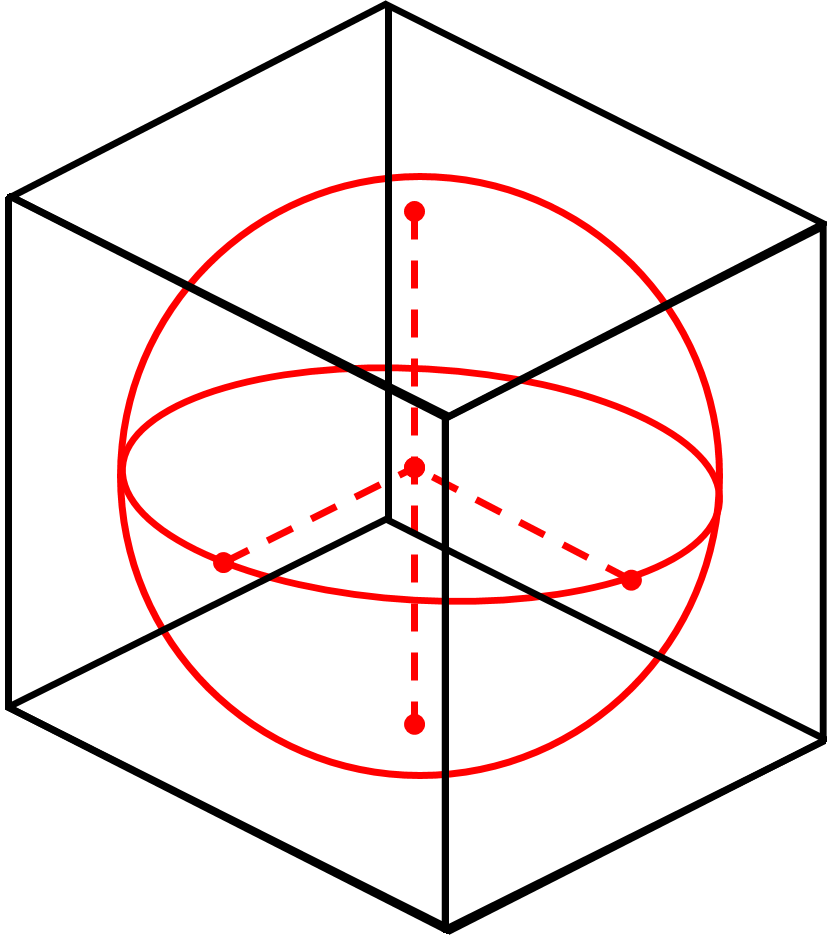
</div>

As max ball you can think of a sphere tangent to the top edges of the polytope.

Now we can use this max ball for rounding the full dimensional polytope. 

## Rounding

Using the A and b of the full dimensional polytope, we build a new HPolytope object.

In [20]:
hp = HPolytope(A_fd, b_fd)

And we use the max ball to round it.

In [ ]:
rounding_polytope = hp.rounding_svd()

Let us see a bit the notion of rounding. Here is a an example of a rather skinny polytope. Polytopes coming from metabolic networks are quite often like this. 

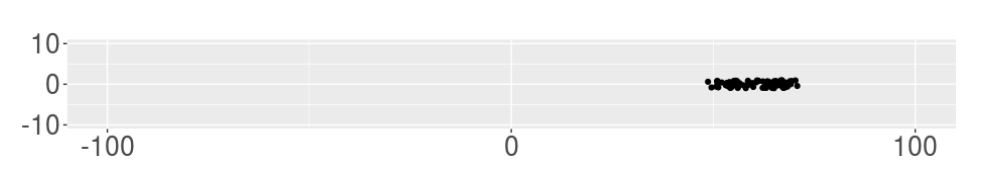

The rounding step transforms these skinny polytopes in way that allows us to obtain a higher quality sample.

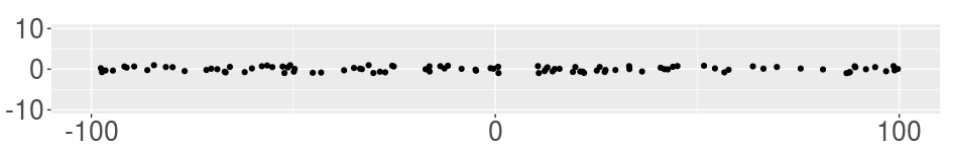

We can now get the features or the rounded polytope.

In [22]:
rounded_A = rounding_polytope[0]
rounded_b = rounding_polytope[1]
rounded_T = rounding_polytope[2]
rounded_shift = rounding_polytope[3]

And use the to get the max ball of this full dimensional, rounded polytope.

In [23]:
rounded_center_point, rounded_radius = get_max_ball(rounded_A, rounded_b)

## Sampling

Finally, we build the full dimenionsal rounded polytope. 

In [24]:
rounded_polytope = HPolytope(rounded_A, rounded_b)

Keep the dimension of the rounded polytope

In [25]:
d = rounded_polytope.dimensions

And calculate the value of the L parameter for the sampling function according the following formula:

In [26]:
L_value = 4 * d * rounded_radius

And using the latter max ball, we sample on it

In [27]:
samples = rounded_polytope.generate_samples(walk_len = 5, 
                                            number_of_points = 10000, 
                                            number_of_points_to_burn = 50, 
                                            radius = rounded_radius, 
                                            inner_point = rounded_center_point,
                                            L = L_value)

Let us now see a few things regarding the parameters we used in the previous command. 
The by default sampling algorithm on volestipy is the Billiard walk. And this is why. 

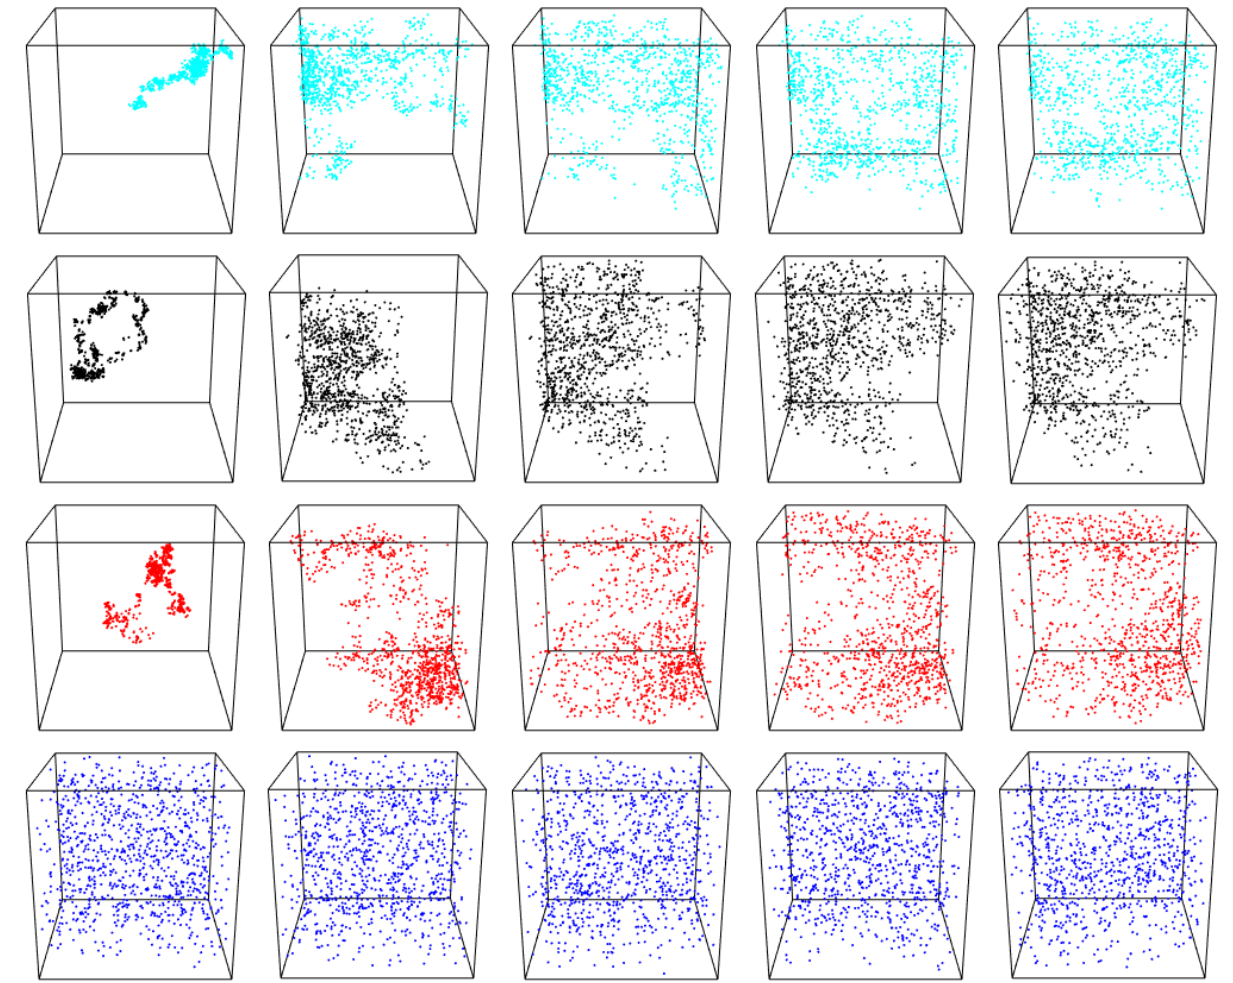

Here we see 4 different samplers (raws):
* Ball Walk
* Coordinate Directions Hit and Run (CDHR)
* Random Directions Hit and Run (RDHR)and 
* Billiard Walk (BW)

In each column, a different walk length has been set: {1, 50, 100, 150, 200}

In case of the BW we see how faster compared to the rest it converges. 

And here is a brief descriptions of how the Billiard Walk works and manages to provide so quality sampling so quickly.

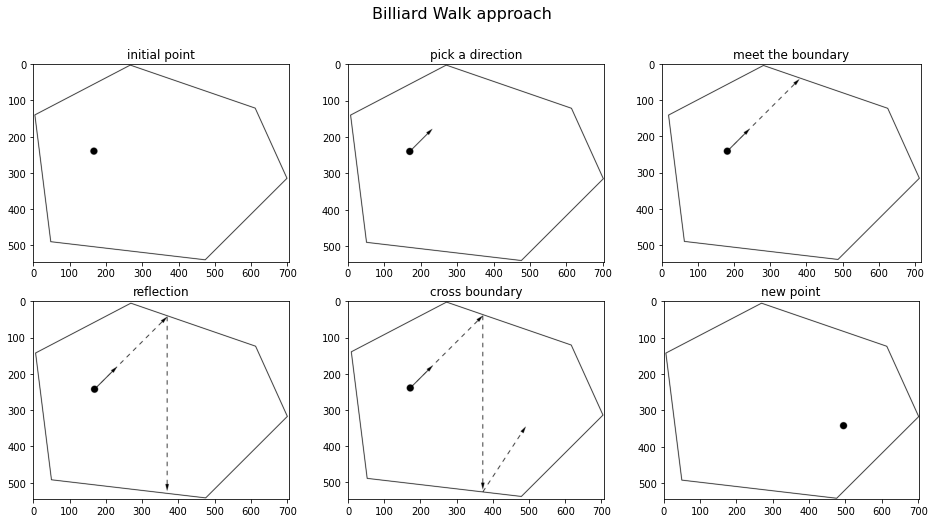

In [2]:
import matplotlib.pyplot as plt
img1 = plt.imread('/home/haris/Desktop/running/volestipy_pipeline/pydata/pydata_figures/initial_point.png')
img2 = plt.imread('/home/haris/Desktop/running/volestipy_pipeline/pydata/pydata_figures/direction.png')
img3 = plt.imread('/home/haris/Desktop/running/volestipy_pipeline/pydata/pydata_figures/reach_edge.png')
img4 = plt.imread('/home/haris/Desktop/running/volestipy_pipeline/pydata/pydata_figures/reflection.png')
img5 = plt.imread('/home/haris/Desktop/running/volestipy_pipeline/pydata/pydata_figures/reach_cross_edge.png')
img6 = plt.imread('/home/haris/Desktop/running/volestipy_pipeline/pydata/pydata_figures/new_point.png')

images = [img1, img2, img3, img4, img5, img6]
labels = ['initial point', 'pick a direction', 'meet the boundary', 'reflection', 'cross boundary', 'new point']

NUM_ROWS = 2
IMGs_IN_ROW = 3

f, ax_arr = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(16,8))

for j, row in enumerate(ax_arr):
    for i, ax in enumerate(row):
        ax.imshow(images[j*IMGs_IN_ROW+i])
        ax.set_title(f'{labels[j*IMGs_IN_ROW+i+1-1]}')

title = 'Billiard Walk approach'
f.suptitle(title, fontsize=16)
plt.show()
hide_toggle()

However, these samples "live" in the world of the rounded, full dimensional polytope. Thus, we need to map them back in our initial polyopte. To do that we run one last ```volestipy``` function, using the features returned from the ```rounding``` and the ```full_dimensional``` functions. 

In [28]:
mapped_samples = map_samples_on_initial_polytope(samples, rounded_T, rounded_shift, N, N_shift)

Let's have a look on our final points and their dimension. 

In [29]:
mapped_samples.shape

(95, 10000)

## Analysis, plots etc.

We will use the ```matplotlib``` library to plot our random samples. First, we download it to our environment.

In [ ]:
pip install matplotlib

Now we can import it.

In [30]:
import matplotlib.pyplot as plt

We mentioned that we are insterested in the HEX1 reaction that we have already kept as a variable and that we saw that its index is 218 on the reactions list.

We keep all the fluxes' values from the points sampled for this reactions in a variable. And we print its shape to be sure that we have got this right.

In [31]:
pgi_fluxes = mapped_samples[2,:]

In [ ]:
pgi_fluxes.shape

Now we can get the minimum and the maximum value of ETOHt2r flux.

In [32]:
maxElement = np.amax(pgi_fluxes)
minElement = np.amin(pgi_fluxes)
maxElement, minElement

(8.277991846281811, -30.404386488570267)

And now we may plot our samples! 

<function matplotlib.pyplot.show(close=None, block=None)>

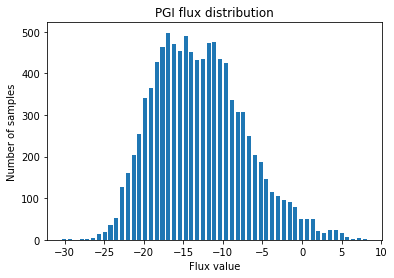

In [33]:
plt.hist(pgi_fluxes, bins='auto', histtype='bar', rwidth=0.7)
plt.xlabel('Flux value')
plt.ylabel('Number of samples')
plt.title('PGI flux distribution')
plt.show

Thank you for your time! Enjoy sampling!

In [ ]:
x = 1
y = 2
print('Result is {} + {}'.format(x, y))

hide_toggle()

## Extras

In case you need to work with ```.mat``` files you need to implement some further steps that are not in the interest of this tutorial. 

To read a ```.mat``` file you need some extra Python libraries, as it is quite a challenging task. If you are more interested in that, you can read this article [here](https://scipy-cookbook.readthedocs.io/items/Reading_mat_files.html).

In [ ]:
## Get the h5py library in case you are working with .mat files of 7.3 release of Matlab and after 
#!sudo -H -S pip install h5py < /home/haris/Desktop/running/metabolic_network_pipeline_volestipy/\
#my_project_virtual_env/error.txt
#print("*** The h5py library has now been installed *** \n\n")

In [ ]:
## Get the tables library to read .mat files
#!sudo -H -S pip3 install tables < /home/haris/Desktop/running/metabolic_network_pipeline_volestipy\
#/my_project_virtual_env/error.txt
#print("*** The tables library has now been installed *** \n\n")

In [ ]:
## Matlab up to 7.1 = mat files created with Matlab up to version 7.1 can be read using the mio module part of scipy.io.
#from scipy.io import loadmat 
#
## Beginning at release 7.3 of Matlab, mat files are actually saved using the HDF5 format by default (except if you use the -vX flag at save time, see in Matlab). These files can be read in Python using, for instance, the PyTables or h5py package
#import tables 
#import h5py

In [ ]:
## Get the ggplot - oriented Python library
#!sudo -H -S pip3 install -t "/home/haris/anaconda3/lib/python3.7/site-packages/" --upgrade pandas plotnine \
#< /home/haris/Desktop/running/metabolic_network_pipeline_volestipy/my_project_virtual_env/error.txt
#print("*** The ggplot for Python library has now been installed *** \n\n")

In [ ]:
#mat_file_with_loadmat = loadmat('/home/haris/Downloads/e_coli_core.mat')

While this one is in case of ```.mat``` files created by releases of Matlab later after the 7.3
This command will not run in any other case.
For this demo we will use the ```loadmat``` option.

In [ ]:
# mat_file_with_tables = h5py.File('/home/haris/Downloads/e_coli_core.mat')

Now you can see your metabolic network. 

In [ ]:
print(mat_file_with_loadmat)

In [ ]:
#data_from_mat = mat_file_with_loadmat
#print("the data type of the variable with the network as it was read is: " + str(type(data_from_mat)))

#s_matrix = data_from_mat.keys()
#print("\nthe keys of this dictionaries are: ")
#print(s_matrix)

#e_coli_np_void = data_from_mat['e_coli_core'][0][0]
#print("\nHowever, if we keep the key:value pair of this dictionary, called 'e_coli_core' where the necessary \
#information is located, we can see that its type is: " + str(type(e_coli_np_void)) + "\n\n")

#print("number of dimensions of the np.void data type equals to:" + str(e_coli_np_void.ndim) + "\n")

#print(type(e_coli_np_void))
#print(len(e_coli_np_void))



## metabolites
#print(type(e_coli_np_void[0]))
#print(e_coli_np_void[0].shape)

#print(type(e_coli_np_void[0][0]))
#print(e_coli_np_void[0][0].shape)

#print(e_coli_np_void[0][:3,])
#metabolites = [item[0][0] for item in e_coli_np_void[0]]
#print(metabolites)

## genes
#print(type(e_coli_np_void[4]))
#print(e_coli_np_void[4].shape)
#print(e_coli_np_void[4][:3,])

## reactions
#print(type(e_coli_np_void[7]))
#print(e_coli_np_void[7].shape)
#print(e_coli_np_void[7][:3,])

In [ ]:
x = np.array([x for x in range(samples.shape[0])])
plt.plot(x, hex1_fluxes)
plt.show()

In [ ]:
#for key,value in data_from_mat.items():
#    print(str(key) + "\t" + str(value))
#    print("\n\n\n\n\n\n")

In [ ]:
rounding_output_max_ellipsoid = hp.rounding(rounding_method = "max_ellipsoid", 
                                            inner_point = max_ball_center_point, 
                                            radius = max_ball_radius)

In case you the ```pre_process``` step had already run, you may load its output using the following commands:

In [ ]:
A_proc = np.load('/home/haris/Documents/GitHub/volesti_fork/volestipy/tests/A_preprocessed.npy')
b_proc = np.load('/home/haris/Documents/GitHub/volesti_fork/volestipy/tests/b_preprocessed.npy')
Aeq_proc = np.load('/home/haris/Documents/GitHub/volesti_fork/volestipy/tests/Aeq_preprocessed.npy')
beq_proc = np.load('/home/haris/Documents/GitHub/volesti_fork/volestipy/tests/beq_preprocessed.npy')

In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

Likewise, for the `scipy` library. Install it through conda on this environment.

In [ ]:
!conda install --yes --prefix {sys.prefix} scipy

We do not need to import `scipy` here, however the `volestipy` does that. 

Finally, we have to compile and then import the ```volestipy``` library. To this end, we first need to get the `cython` library.

In [ ]:
pip install Cython

And then run the following command as it was from our terminal. It is the `!` that allows for the latter.

In [ ]:
!LDFLAGS="-L/usr/lib/lp_solve/" python3 setup.py install --user

Now we are ready to read our network BIGG file and run the necessary steps to get our random points from its correspoding polytope.

In [ ]:
import matplotlib.pyplot as plt
img1 = plt.imread('/home/haris/Desktop/running/volestipy_pipeline/pydata/pydata_figures/initial_point.png')
img2 = plt.imread('/home/haris/Desktop/running/volestipy_pipeline/pydata/pydata_figures/direction.png')
img3 = plt.imread('/home/haris/Desktop/running/volestipy_pipeline/pydata/pydata_figures/reach_edge.png')
img4 = plt.imread('/home/haris/Desktop/running/volestipy_pipeline/pydata/pydata_figures/reflection.png')
img5 = plt.imread('/home/haris/Desktop/running/volestipy_pipeline/pydata/pydata_figures/reach_cross_edge.png')
img6 = plt.imread('/home/haris/Desktop/running/volestipy_pipeline/pydata/pydata_figures/new_point.png')

images = [img1, img2, img3, img4, img5, img6]
labels = ['initial point', 'pick a direction', 'reach boundary', 'reflection', 'reach opposite boundary', 'new point']

NUM_ROWS = 2
IMGs_IN_ROW = 3

f, ax_arr = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(16,8))

for j, row in enumerate(ax_arr):
    for i, ax in enumerate(row):
        ax.imshow(images[j*IMGs_IN_ROW+i])
        ax.set_title(f'{labels[j*IMGs_IN_ROW+i+1-1]}')

title = 'Billiard Walk method'
f.suptitle(title, fontsize=16)
plt.show()  